## Méthode Linear Regression sur le dataset LivingRoom_preprocessed_hack

In [5]:
import os

import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt

### Récupérer les données du challenge

In [14]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [15]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [16]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [62]:
import numpy as np
import pandas as pd

# Load the Empty Room .npy file
data_empty = np.load('data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')


# Load the Human1 Room .npy file
data_H1_target = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
data_H1_features = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
#data_array_H1_skeletons = np.load('data/LivingRoom_preprocessed_hack/Human1/skeletons.npy')


# Load the Human2 Room .npy file
data_H2_target = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
data_H2_features = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
#data_array_H2_skeletons = np.load('data/LivingRoom_preprocessed_hack/Human2/skeletons.npy')



### **Exploration des données**

### Salle vide

**Affichage des données dans la salle vide**

In [63]:
# affichage de la taille du dataset de la salle vide
print(data_empty.shape)

(100, 10, 667200)


On a un dataset de 1000 datapoints (ou expériences), 10 microphones et 667200 samples (ou enregistrements). Essayons de voir le contenu du dataset.

In [64]:
# afficahge du dataset de la salle vide
print(data_empty)

[[[ 3.51455710e-05  2.98663563e-05  3.73540461e-05 ...  3.15141187e-05
    3.39845319e-05  3.76356365e-05]
  [ 2.16268872e-05  1.10792007e-05  2.40492645e-05 ...  1.01209635e-05
    1.73616045e-05  8.96632082e-06]
  [ 2.06858294e-05  1.90607770e-05  2.63220481e-05 ...  1.43677271e-05
    1.95061293e-05  1.58852017e-05]
  ...
  [ 3.27473884e-07 -3.45638477e-06  6.21833306e-06 ...  1.55723665e-05
    7.87512818e-06  1.52851735e-05]
  [-3.58676079e-05 -3.13848795e-05 -2.27468136e-05 ... -3.73245530e-06
   -5.06659762e-06 -9.37922323e-06]
  [ 2.69082539e-05  1.57103223e-05  2.85315637e-05 ...  1.50174383e-05
    1.78934224e-05  1.78581904e-05]]

 [[-2.38466669e-06 -1.65329311e-06 -2.45740762e-06 ...  3.55113252e-06
    7.89113926e-07  5.85643602e-06]
  [ 3.67970802e-06  3.20152003e-06  7.42820293e-06 ...  1.00465177e-05
    8.65629227e-06  1.03361735e-05]
  [ 1.15234134e-05  9.68922814e-06  1.62094748e-05 ...  4.92468780e-06
    7.93941035e-06  4.21444474e-06]
  ...
  [-3.29118811e-05 -3.0

On suppose qu'il s'agit d'amplitude de gain. On peut essayer de tracer les enregistrements de 10 microphones. Essayons d'afficher les enregistrements des 10 microphones en fonction du temps.

**Affichage des enregistrements de la salle vide**

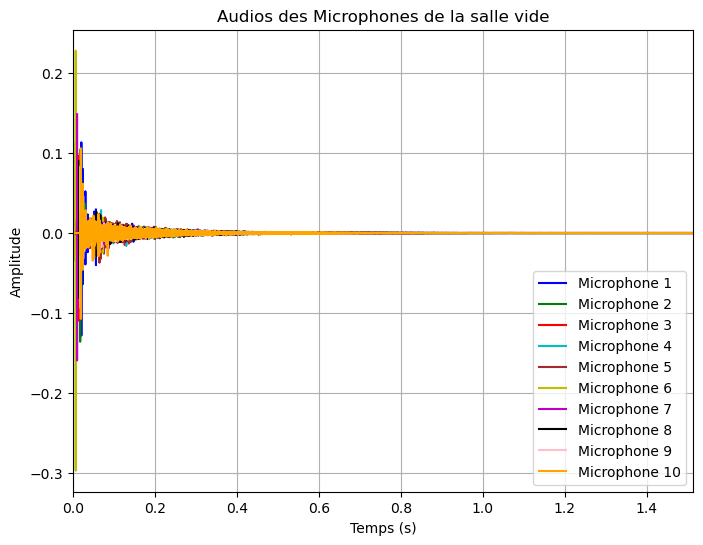

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre de micros
num_micros = data_empty.shape[1]

# Nombre de samples
num_samples = data_empty.shape[2]

# Durée de l'enregistrement en secondes (supposant un échantillonnage à 44100 Hz)
duration = num_samples / 44100

# Création de la grille de temps
time = np.linspace(0, duration, num_samples)

# Affichage des audios pour chaque micro sur un seul graphique avec des couleurs différentes
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c','brown','y','m','k','pink','orange']  # Couleurs pour chaque micro

for i in range(num_micros):
    plt.plot(time, data_empty[0, i, :], color=colors[i], label='Microphone {}'.format(i+1))

plt.title('Audios des Microphones de la salle vide')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.xlim(0, duration/10)  # Réduire l'axe du temps pour montrer seulement une partie de l'enregistrement
plt.grid(True)
plt.legend()
plt.show()

On peut voir qu'on a un gros pic au début qui correspond au bruit du speaker et après l'amplitude s'atténue. On pourra donc essayer de faire des modèles en utilisant la totalité du dataset et une partie du dataset (en l'occurrence le début où il y a le plus de bruit)

### **Travail sur la salle Human1**

**Affichage du dataset centroid (position (x,y) de l'humain)**

Découvrons la taille du dataset centroid.

In [66]:
print(data_H1_target.shape)
print(data_H1_target)

(1000, 2)
[[-3231.3293467  -1127.87771457]
 [-3198.54107875  -744.5100656 ]
 [-3192.9776274   -248.26678827]
 ...
 [-1717.89923578 -3166.59648491]
 [-1808.60337549 -2779.13038427]
 [   44.43741322   106.48353609]]


Ici on a 1000 datapoints et 2 coordonnées (x et y)

Essayons d'afficher les positions de l'humain à chaque expérience(datapoint), ainsi que la position du speaker et des 4 microphones.

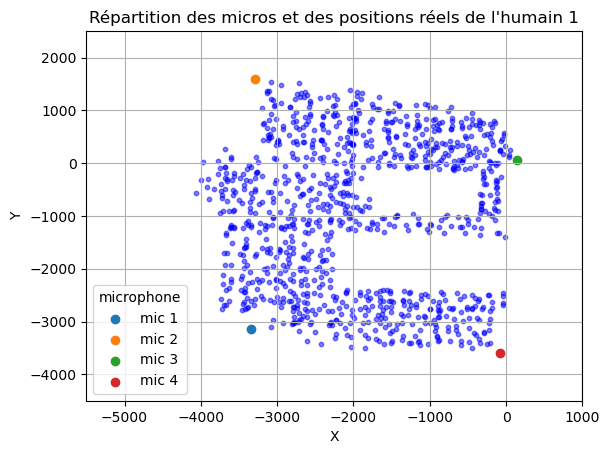

In [67]:
x = data_H1_target[:, 0]
y = data_H1_target[:, 1]

import numpy as np

# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')
plt.scatter(x, y, s=10, c='blue', marker='o', alpha=0.5)  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.title("Répartition des micros et des positions réels de l'humain 1")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

plt.show()

Découvrons maintenant le contenu des enregistrements réalisés dans cette salle.

**Affichage du dataset audio de la salle Human1 deconvoled**

In [68]:
print(data_H1_features.shape)
print(data_H1_features)

(1000, 4, 667200)
[[[ 9.07240337e-06  1.71257434e-05  1.22597794e-05 ...  8.86178623e-06
    1.40686043e-05  1.06616626e-05]
  [-8.23853679e-06 -8.23373648e-06 -8.74563466e-06 ...  2.87394778e-06
   -8.90485808e-06 -3.52464713e-06]
  [ 6.62780906e-07 -1.40201587e-06  1.83228190e-06 ... -1.06218545e-06
    8.53497477e-06  2.28155182e-06]
  [ 8.11119719e-07 -2.47451499e-06  5.82140547e-06 ...  7.73804004e-06
    2.29692650e-05  1.10566034e-05]]

 [[ 1.64466037e-05  1.53698293e-05  1.91599720e-05 ...  1.76548729e-05
    1.70955263e-05  1.41169767e-05]
  [ 1.05826217e-07  9.13145777e-06  1.76140716e-07 ...  1.21369967e-05
    1.55958387e-05  1.23088676e-05]
  [ 7.06836090e-06  3.26818258e-06  7.15508941e-06 ...  4.64980394e-06
    8.96262554e-06  6.55734584e-06]
  [-3.18089551e-05 -8.93297238e-06 -2.51026504e-05 ... -7.02741545e-07
    1.34268867e-05  3.24307348e-06]]

 [[ 4.71092753e-05  4.42863784e-05  4.81883108e-05 ...  5.11715079e-05
    4.54165129e-05  4.68136932e-05]
  [-2.25045878e

On a un dataset de 1000 datapoints (ou expériences), 4 microphones et 667200 samples (ou enregistrements). Il s'agit d'amplitude de gain. On peut essayer de tracer les enregistrements de 4 microphones.

**Affichage des audios**

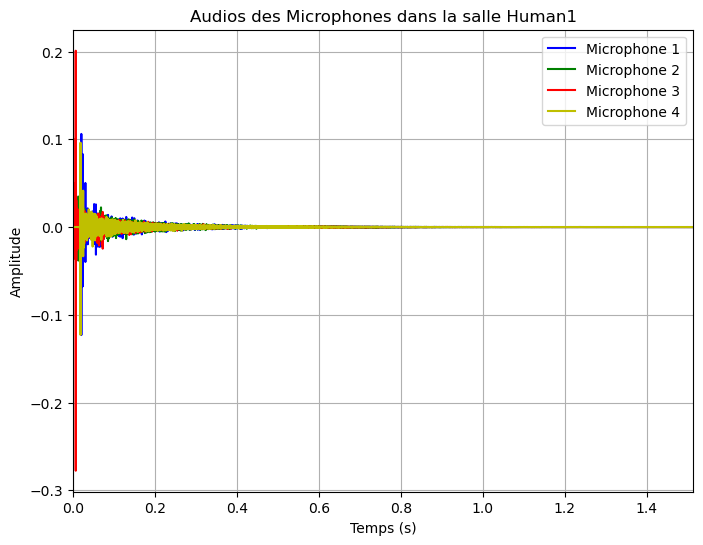

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre de micros
num_micros = data_H1_features.shape[1]

# Nombre de samples
num_samples = data_H1_features.shape[2]

# Durée de l'enregistrement en secondes (supposant un échantillonnage à 44100 Hz)
duration = num_samples / 44100

# Création de la grille de temps
time = np.linspace(0, duration, num_samples)

# Affichage des audios pour chaque micro sur un seul graphique avec des couleurs différentes
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'y']  # Couleurs pour chaque micro

for i in range(num_micros):
    plt.plot(time, data_H1_features[0, i, :], color=colors[i], label='Microphone {}'.format(i+1))

plt.title('Audios des Microphones dans la salle Human1')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.xlim(0, duration/10)  # Réduire l'axe du temps pour montrer seulement une partie de l'enregistrement
plt.grid(True)
plt.legend()
plt.show()

On peut voir qu'on a un gros pic au début qui correspond au bruit du speaker et après l'amplitude s'atténue. On pourra donc essayer de faire des modèles en utilisant la totalité du dataset et une partie du dataset (en l'occurrence le début où il y a le plus de bruit)

### **Développement de modèles de prédictions de positions**

**Modèle 1: Utilisation de la RMS pour traiter nos données et effectuer la régression linéaire**

In [70]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Dans un premier temps on va utiliser tout le dataset audio de la salle Human1

In [72]:
X = data_H1_features[:,:,:int(data_H1_features.shape[2])]
#X = data_H1_features[:,:,:int(data_H1_features.shape[2]*0.3)] à uncomment pour utiliser 30% du dataset audio
y = data_H1_target

print(X.shape)
print(y.shape)

(1000, 4, 667200)
(1000, 2)


La racine carrée de la moyenne des carrés (RMS) est une mesure de l'amplitude moyenne d'un signal audio. La RMS capture l'énergie globale du signal audio sur une période de temps donnée. Cela peut être utile pour différencier les signaux forts des signaux faibles, ce qui peut être pertinent dans votre cas pour distinguer les moments où un humain est présent dans la pièce.

In [73]:
# Calcul de la RMS pour chaque canal (microphone)
rms_data = np.sqrt(np.mean(np.square(X), axis=2))
print(rms_data.shape)
# Normaliser les données RMS
scaler = StandardScaler()
rms_data = rms_data.reshape(1000,-1)
rms_data_normalized = scaler.fit_transform(rms_data)
print(rms_data_normalized)

(1000, 4)
[[  0.807686     0.89319843   0.3703625    0.55446833]
 [  0.6148092    0.5601817    0.32530993   0.49623522]
 [  0.6670591    0.46835804   0.26275572   0.5050229 ]
 ...
 [  0.48971906   0.02091012  -0.3304132   -0.05839473]
 [  0.38563752  -0.5528933   -0.33424938  -0.18044513]
 [  0.38350895   0.30132347 -10.254325    -4.594716  ]]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(rms_data_normalized,y,test_size=0.2,random_state=42)

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# initialiser le modèle de régression
linear_regression_model = LinearRegression()

# entraîner le modèle avec les données d'entraînements
linear_regression_model.fit(X_train, y_train)

# faire les prédictions avec le dataset de test
predictions = linear_regression_model.predict(X_test)

# évaluer le modèle
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)


Test MSE: 1379956.1731800777
Test MAE: 994.9644834742676
Test R²: 0.16508653701175757


In [76]:
import numpy as np

# Calculer la distance euclidienne entre les coordonnées prédites et les coordonnées réelles
def euclidean_distance(y_true, y_pred):
    # Calculer la différence entre les coordonnées prédites et réelles
    diff = y_true - y_pred
    # Calculer la distance euclidienne pour chaque point
    distances = np.linalg.norm(diff, axis=1)
    return distances

# Utiliser la fonction pour calculer les distances euclidiennes pour les prédictions actuelles
distances = euclidean_distance(y_test, predictions)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)


Mean Euclidean Distance: 1544.234908824


**Méthode 2: Utilisation de PCA pour traiter les données audios et effectuer la régression linéaire**

In [77]:
from sklearn.decomposition import PCA

X_reshaped = X.reshape(1000,-1)
pca = PCA(n_components=100)
H1_dec = pca.fit_transform(X_reshaped)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_scaled =  scaler.fit_transform(H1_dec)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=42)

L_Reg = LinearRegression()

L_Reg.fit(X_train, y_train)

y_preds = L_Reg.predict(X_test)

distances = euclidean_distance(y_test, y_preds)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)

# évaluer le modèle
mse = mean_squared_error(y_test, y_preds)
mae = mean_absolute_error(y_test, y_preds)
r2 = r2_score(y_test, y_preds)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)


Mean Euclidean Distance: 652.3638386524285
Test MSE: 327686.6654256723
Test MAE: 410.8225340982258
Test R²: 0.783577762887036


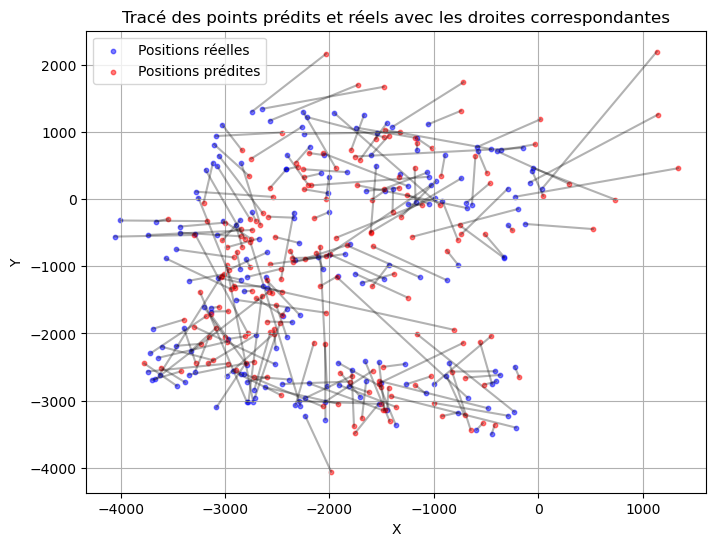

In [79]:
X_test_plot = y_test[:, 0]
y_test_plot = y_test[:, 1]

X_preds_plot = y_preds[:, 0]
y_preds_plot = y_preds[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(X_test_plot, y_test_plot, s=10, c='blue', marker='o', alpha=0.5, label='Positions réelles')
plt.scatter(X_preds_plot, y_preds_plot, s=10, c='red', marker='o', alpha=0.5, label='Positions prédites')  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence

for i in range(len(X_test_plot)):
    plt.plot([X_test_plot[i], X_preds_plot[i]], [y_test_plot[i], y_preds_plot[i]], c='black', alpha=0.3)

plt.title('Tracé des points prédits et réels avec les droites correspondantes')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [80]:
import numpy as np

# Calcul de la distance euclidienne entre chaque position prédite et réelle
distances_euclidiennes = np.sqrt((X_preds_plot - X_test_plot)**2 + (y_preds_plot - y_test_plot)**2)

# Comparaison et calcul de l'accuracy
predictions_correctes = np.sum(distances_euclidiennes <= mean_distance)
accuracy = predictions_correctes / len(distances_euclidiennes)

print("Précision du modèle :", accuracy*100)

Précision du modèle : 60.5


### Travail sur la salle H2

**Affichage du centroid**

In [81]:
print(data_H2_target.shape)
print(data_H2_target)

(104, 2)
[[-2406.85413008 -2443.62906004]
 [-1923.16230038 -2504.30576997]
 [-1615.29307549 -2525.71107555]
 [-1234.84729435 -2581.21590946]
 [ -906.89320474 -2648.96828851]
 [ -579.82451164 -2563.38746474]
 [ -258.89043633 -2501.99822189]
 [ -237.00812692 -2957.79113999]
 [ -608.16773853 -2894.26845589]
 [ -920.67771947 -2892.68441764]
 [-1177.38289287 -3050.12473983]
 [-1690.95162773 -3023.00826184]
 [-1968.49135428 -3048.59689339]
 [-2401.44182176 -2925.40384273]
 [-2626.65068051 -2353.52639219]
 [-2945.10567004 -2270.29924636]
 [-3288.80884616 -2179.77519901]
 [-3543.43725461 -2122.72140672]
 [-3818.97939345 -2074.06640841]
 [-3787.00508742 -1745.78914635]
 [-3440.47071217 -1786.24662486]
 [-3126.89926719 -1778.7456592 ]
 [-2780.8277654  -1806.35696377]
 [-2443.03492952 -1839.64542774]
 [-2359.37110303 -1517.60616977]
 [-2643.69001771 -1476.99863966]
 [-3045.54399981 -1635.42668901]
 [-3302.78792751 -1472.55710516]
 [-3760.33837488 -1417.04328708]
 [-4041.78587419 -1398.58686915]
 

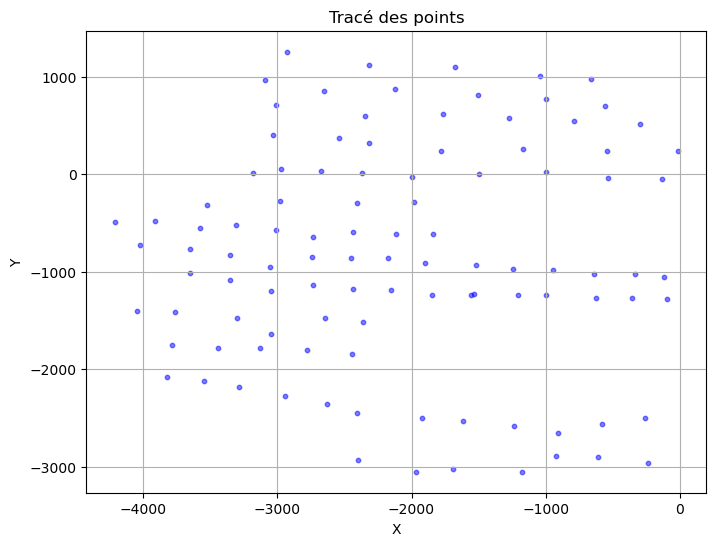

In [82]:
x = data_H2_target[:, 0]
y = data_H2_target[:, 1]

# Tracer les points
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, c='blue', marker='o', alpha=0.5)  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence
plt.title('Tracé des points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

**Affichage et process du deconvoled**

In [83]:
print(data_H2_features.shape)
print(data_H2_features)

(104, 4, 667200)
[[[ 1.32263867e-05  4.04477396e-06  1.72964337e-05 ...  1.42459985e-05
    7.06920127e-06  1.52228458e-05]
  [ 1.66781626e-06  4.13932912e-06  4.92448726e-06 ...  1.69338909e-05
    1.40092038e-06  1.19383767e-05]
  [ 1.15825042e-05  4.49341405e-06  1.40825741e-05 ...  1.12802718e-05
    1.38609530e-05  6.46868511e-06]
  [-2.10553353e-05 -2.40086247e-05 -1.06697380e-05 ... -2.20970142e-05
   -2.00329578e-05 -2.09568789e-05]]

 [[-7.21401693e-06  1.12978867e-07 -4.36823848e-06 ... -1.81246889e-06
   -8.53981510e-06 -1.84635439e-06]
  [ 1.36644203e-05  2.30385322e-05  1.24044136e-05 ...  9.66903553e-06
    1.00616371e-05  1.03869361e-05]
  [ 2.78378029e-05  1.38622945e-05  2.71665067e-05 ...  1.33699305e-05
    1.06378029e-05  1.05457875e-05]
  [ 1.15678056e-04  1.64297759e-04  5.92336910e-05 ...  5.16751425e-05
    3.32121781e-05  1.38982023e-05]]

 [[-1.59124454e-06 -9.91511479e-06  1.74267120e-06 ...  3.94251998e-07
    2.68778354e-06  2.13934914e-06]
  [ 7.30616648e-

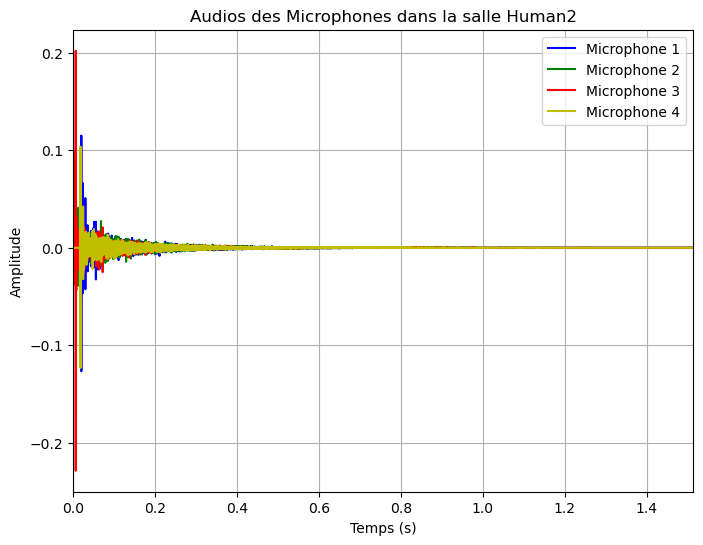

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre de micros
num_micros = data_H2_features.shape[1]

# Nombre de samples
num_samples = data_H2_features.shape[2]

# Durée de l'enregistrement en secondes (supposant un échantillonnage à 44100 Hz)
duration = num_samples / 44100

# Création de la grille de temps
time = np.linspace(0, duration, num_samples)

# Affichage des audios pour chaque micro sur un seul graphique avec des couleurs différentes
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'y']  # Couleurs pour chaque micro

for i in range(num_micros):
    plt.plot(time, data_H2_features[0, i, :], color=colors[i], label='Microphone {}'.format(i+1))

plt.title('Audios des Microphones dans la salle Human2')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.xlim(0, duration/10)  # Réduire l'axe du temps pour montrer seulement une partie de l'enregistrement
plt.grid(True)
plt.legend()
plt.show()

In [87]:
X = data_H2_features[:,:,:int(data_H1_features.shape[2])]
#X = data_H2_features[:,:,:int(data_H1_features.shape[2]*0.3)] à uncomment pour tester avec 30% du dataset audio
y = data_H2_target

print(X.shape)
print(y.shape)

(104, 4, 667200)
(104, 2)


In [88]:
# Calcul de la RMS pour chaque canal (microphone)
rms_data = np.sqrt(np.mean(np.square(X), axis=2))
print(rms_data.shape)
# Normaliser les données RMS
scaler = StandardScaler()
rms_data = rms_data.reshape(104,-1)
rms_data_normalized = scaler.fit_transform(rms_data)
print(rms_data_normalized)

(104, 4)
[[ 5.74566066e-01  4.70529318e-01  3.15720111e-01  4.25534368e-01]
 [ 7.34085023e-01  8.18496227e-01  1.34477586e-01  4.07370448e-01]
 [ 6.69064760e-01  8.17484617e-01  6.40565231e-02  4.75006759e-01]
 [ 7.00353563e-01  7.17961550e-01  1.17393918e-01  4.88678545e-01]
 [ 6.00994229e-01 -2.68238387e-03  1.79196984e-01  2.52244771e-01]
 [ 6.20301068e-01  3.12822402e-01  1.66690871e-01  5.40538669e-01]
 [ 7.75909305e-01  8.82715583e-01  1.45695016e-01 -3.80226684e+00]
 [ 8.45549703e-01  4.75916922e-01  2.35704988e-01 -3.89201665e+00]
 [ 7.00217843e-01  2.43397251e-01  1.20823078e-01  3.09324086e-01]
 [ 7.22152352e-01  6.74702078e-02  1.06801793e-01  3.53230238e-01]
 [ 9.08574462e-01  3.94216210e-01  1.83692366e-01  2.75201708e-01]
 [ 9.62464035e-01  7.59573460e-01  9.10689384e-02  2.51561612e-01]
 [ 6.80784523e-01  6.35953963e-01  7.57950395e-02  4.10718113e-01]
 [ 7.13868320e-01 -1.14946984e-01  1.50416881e-01  2.79307187e-01]
 [-2.10923600e+00  4.19585735e-01  2.11452350e-01  3.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(rms_data_normalized,y,test_size=0.2,random_state=42)

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# initialiser le modèle de régression
linear_regression_model = LinearRegression()

# entraîner le modèle avec les données d'entraînements
linear_regression_model.fit(X_train, y_train)

# faire les prédictions avec le dataset de test
predictions = linear_regression_model.predict(X_test)

# évaluer le modèle
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)

Test MSE: 1166141.2852851013
Test MAE: 891.2021694250666
Test R²: 0.07036722160025666


In [91]:
import numpy as np

# Calculer la distance euclidienne entre les coordonnées prédites et les coordonnées réelles
def euclidean_distance(y_true, y_pred):
    # Calculer la différence entre les coordonnées prédites et réelles
    diff = y_true - y_pred
    # Calculer la distance euclidienne pour chaque point
    distances = np.linalg.norm(diff, axis=1)
    return distances

# Utiliser la fonction pour calculer les distances euclidiennes pour les prédictions actuelles
distances = euclidean_distance(y_test, predictions)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)

Mean Euclidean Distance: 1413.1854196696859


In [92]:
from sklearn.decomposition import PCA

X_reshaped = X.reshape(104,-1)
pca = PCA(n_components=100)
H1_dec = pca.fit_transform(X_reshaped)

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_scaled =  scaler.fit_transform(H1_dec)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=42)

L_Reg = LinearRegression()

L_Reg.fit(X_train, y_train)

y_preds = L_Reg.predict(X_test)

distances = euclidean_distance(y_test, y_preds)

# Calculer la moyenne des distances
mean_distance = np.mean(distances)

print("Mean Euclidean Distance:", mean_distance)

# évaluer le modèle
mse = mean_squared_error(y_test, y_preds)
mae = mean_absolute_error(y_test, y_preds)
r2 = r2_score(y_test, y_preds)




print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)

Mean Euclidean Distance: 1402.71701905254
Test MSE: 1126577.6285871752
Test MAE: 885.3757328176844
Test R²: 0.069962886269475


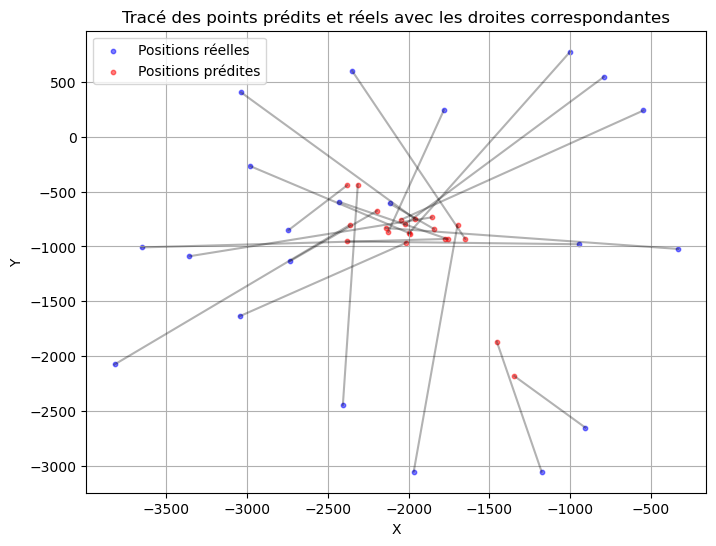

In [94]:
X_test_plot = y_test[:, 0]
y_test_plot = y_test[:, 1]

X_preds_plot = y_preds[:, 0]
y_preds_plot = y_preds[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(X_test_plot, y_test_plot, s=10, c='blue', marker='o', alpha=0.5, label='Positions réelles')
plt.scatter(X_preds_plot, y_preds_plot, s=10, c='red', marker='o', alpha=0.5, label='Positions prédites')  # s: taille des points, c: couleur, marker: type de marqueur, alpha: transparence

for i in range(len(X_test_plot)):
    plt.plot([X_test_plot[i], X_preds_plot[i]], [y_test_plot[i], y_preds_plot[i]], c='black', alpha=0.3)

plt.title('Tracé des points prédits et réels avec les droites correspondantes')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [95]:
import numpy as np

# Calcul de la distance euclidienne entre chaque position prédite et réelle
distances_euclidiennes = np.sqrt((X_preds_plot - X_test_plot)**2 + (y_preds_plot - y_test_plot)**2)

# Comparaison et calcul de l'accuracy
predictions_correctes = np.sum(distances_euclidiennes <= mean_distance)
accuracy = predictions_correctes / len(distances_euclidiennes)

print("Précision du modèle :", accuracy*100)

Précision du modèle : 42.857142857142854
